In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, roc_curve, ConfusionMatrixDisplay)
from sklearn import metrics
from matplotlib.colors import LinearSegmentedColormap

# Pre-processing

## Remove text data and rate

In [2]:
def remove_data(df):
    """
    remove columns with text
    
    df: dataframe of articles
    """
    
    df.drop(['title', 'text', 'rate', 'clean_text'], axis=1, inplace = True)
    return df

In [3]:
def cat_to_num(df):
    """
    convert categorical value to numerical
    
    df: dataframe of articles
    """
    
    # order of the number does matter
    importance = {'Top': 1,
                  'High': 2,
                  'Mid': 3,
                  'Low': 4,
                  'Bottom': 5,
                  'Unknown': 6}
    classes = {'High': 1, 'Low': 0}

    df['2_classes'] = df['2_classes'].map(classes)
    df['importance'] = df['importance'].map(importance)
    return df

## Split Data

In [4]:
def split_data(df):
    """
    split data into 70%/30% for modelling
    
    df: dataframe of articles
    """

    X = df.iloc[:, 0:-1]
    y = df.iloc[:, -1] # last column is the 2_class which is the dependent variable

    # use stratify so train and test set have same distribution of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

# Modelling

In [5]:
def modelling(algorithm, X_train, X_test, y_train, y_test):
    """
    train classification model with cross validation (train/validation/test)
    
    algorithm: the model used for classification
    X_train: independent variables from train set
    X_test: independent variables from test set
    y_train: dependent variable from train set
    y_test: dependent variable from test set
    """
    
    # cross validation while maintaining the distribution of data
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    cv_accuracies = []
    best_accuracy = 0
    
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
        # create a pipeline to normalise value before building model
        pipe = Pipeline([("scaler", MinMaxScaler()),
                         ("model", algorithm)])
        pipe.fit(X_train_fold, y_train_fold)
    
        y_val_pred = pipe.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        
        cv_accuracies.append(accuracy)
        
        # capture the best model throughout the cross validation
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = pipe.steps[1][1]
            
    avg_cv_accuracy = sum(cv_accuracies) / 5
    print(f"Average Cross-Validation Accuracy: {avg_cv_accuracy:.2f}")
    print(f"Best Cross-Validation Accuracy: {best_accuracy:.2f}")
    
    # train the best model with the entire data
    pipe = Pipeline([("scaler", MinMaxScaler()),
                     ("model", best_model)])
    pipe.fit(X_train, y_train)
    
    y_test_pred = pipe.predict(X_test)
    y_test_proba = pipe.predict_proba(X_test)[:, 1]
    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Set Accuracy: {test_accuracy:.2f}")
    
    return best_model, y_test_pred, y_test_proba

In [6]:
def gridsearchcv_modelling(algorithm, X_train, X_test, y_train, y_test, param_grid):
    """
    train classification model with Grid Search Cross Validation to look for best parameters
    
    algorithm: the model used for classification
    X_train: independent variables from train set
    X_test: independent variables from test set
    y_train: dependent variable from train set
    y_test: dependent variable from test set
    param_grid: different values for parameters
    """ 
    
    # create a pipeline to normalise value before building model
    pipe = Pipeline([("scaler", MinMaxScaler()),
                     ("model", algorithm)])
    
    skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)
    
    grid_search = GridSearchCV(pipe, param_grid, cv=skf.split(X_train,y_train), scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Classifier accuracy: {accuracy:.2f}")
    
    print(f"Best parameters: {grid_search.best_params_}")
    
    return best_model.named_steps['model'], y_pred, y_proba

# Feature Importance

In [7]:
def plot_importance(algo_name, model, X_test, y_test, feature_names, save = False):
    """
    bar chart for the importance of each features in the model
    
    algo_name: the name of the model used for classification
    model: the trained classification model
    X_test: independent variables from test set
    y_test: dependent variable from test set
    feature_names: name of all features used in classification
    """
    
    # Naive Bayes does not have built-in feature importance so need to use permutation importance
    if algo_name == "Naive Bayes":
        results = permutation_importance(model, X_test, y_test, scoring='f1', n_jobs = -1)
        importance = results.importances_mean
        print(importance)
    # Logistic Regression has coefficient to show how change in feature value impact the result
    elif algo_name in ["Logistic Regression"]:
        importance = model.coef_[0]
    # K-Nearest Neighbors and Support Vector Machine cannot calculate feature importance
    elif algo_name in ["K-Nearest Neighbors", "Support Vector Machine"]:
        return
    # Decision Tree and Random Forest has built-in feature importance
    else:
        try:
            importance = model.feature_importances_
        except AttributeError:
            warnings.warn(f"The model {algo_name} does not support feature importances.")
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importance in {algo_name}")
    bars = plt.bar(range(len(importance)), importance, width=0.7)
    plt.xticks(range(len(importance)), feature_names, rotation=90)
    
    # create text to show feature importance score
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3),
                 ha='center', va='bottom', fontsize=8)
    
    # save image
    if algo_name == "Random Forest" and save:
        image_name = "Feature Importance"
        plt.savefig(f"../Report/Image/{algo_name}_{image_name}", dpi=300, bbox_inches='tight', transparent=True)
    
    plt.show()

In [8]:
def plot_PDP(algo_name, model, X_train, feature_names):

    fig, axs = plt.subplots(7, 3, figsize=(20, 20), constrained_layout=True)

    # Flatten the array of axes for easy iteration
    axs = axs.flatten()

    # Plot PDP for each feature
    for i, feature in enumerate(feature_names):
        if i < len(axs):
            # Plot PDP for the current feature
            disp = PartialDependenceDisplay.from_estimator(model, X_train, features=[i], ax=axs[i])
            # Set the title for each subplot
            axs[i].set_title(f'Feature: {feature}')
        else:
            # Hide any unused subplots
            axs[i].axis('off')

    # Hide any unused subplots (if n_features < n_cols * n_rows)
    for j in range(len(feature_names), len(axs)):
        axs[j].axis('off')

    plt.show()

# Measure Performance

## Performance Matrix

In [9]:
def performance_matrix(y_test, y_pred, y_proba):
    """
    calculate multiple performance matrix
    
    y_test: dependent variable from test set
    y_pred: predicted category of test set
    y_proba: predicted probability of test set
    """
    
    accuracy = round(accuracy_score(y_test, y_pred),2)
    precision = round(precision_score(y_test, y_pred),2) # propotion of positive predictions was actually correct
    recall = round(recall_score(y_test, y_pred),2) # proportion of actual positives was identified correctly
    f1 = round(f1_score(y_test, y_pred),2)
    auc = round(roc_auc_score(y_test, y_proba),2)
    
    metrics_df = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1 Score'],
                               'Value': [accuracy, precision, recall, auc, f1]})
    display(metrics_df)

## Confusion Matrix

In [10]:
def visualise_conf_max(y_test, y_pred, algo_name, balance = False, save = False):
    """
    draw confusion matrix
    
    y_test: dependent variable from test set
    y_pred: predicted category of test set
    algo_name: the name of the model used for classification
    balance: whether dataset is balance
    save: whether to save the plot
    """
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    reversed_confusion_matrix = confusion_matrix[::-1, ::-1]
    colors = ["#C35F4A", "#EEF6F0", "#FFB03A"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_red_blue", colors)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = reversed_confusion_matrix, 
                                                display_labels=['High', 'Low'])

    ax = cm_display.plot(cmap=custom_cmap, colorbar=False)
    if balance:
        title = "Balance Class"
    else:
        title = "Imbalance Class"
    ax.ax_.set_title(f'Confusion Matrix for {title}', fontdict={"fontsize":20})

    # adjust display of the text
    for text in ax.ax_.texts:
        text.set_fontsize(20)
        text.set_color('black') 
        text.set_fontweight('bold')

    # add gridline for confusion matrix
    ax.ax_.axhline(y=0.5, color='black', linewidth=1)
    ax.ax_.axvline(x=0.5, color='black', linewidth=1)
    
    ax.ax_.set_xlabel('Predicted label', fontsize=20)
    ax.ax_.set_ylabel('True label', fontsize=20)

    ax.ax_.tick_params(axis='both', which='major', labelsize=18)

    # save image
    if save and balance:
        image_name = "Confusion Matrix (Balance)"
        plt.savefig(f"../Report/Image/{algo_name}_{image_name}", dpi=300, bbox_inches='tight', transparent=True)
    elif save and not balance:
        image_name = "Confusion Matrix (Imbalance)"
        plt.savefig(f"../Report/Image/{algo_name}_{image_name}", dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

## ROC Curve

In [11]:
def visualise_roc_curve(result_proba):
    """
    ROC curve for all model
    
    result_proba: dictionary of model name and predicted probability
    """
    
    for name, y in result_proba.items():
        y_test, y_proba = y[0], y[1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Classifiers')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
def prepare_data(df):
    """
    Prepare the data before building classification model
    
    df: dataframe of articles
    """
    
    df = remove_data(df)
    df = cat_to_num(df)
    X_train, X_test, y_train, y_test = split_data(df)
    
    return df, X_train, X_test, y_train, y_test

In [13]:
algorithms = {"Decision Tree": DecisionTreeClassifier(), 
              "Random Forest": RandomForestClassifier()}

def prediction_analysis(df, X_train, X_test, y_train, y_test, algo_name, param_grid = None,
                        balance = False, save = False, cv = False, pdp = False):
    """
    build classification model and visualise result
    
    df: dataframe of articles
    X_train: independent variables from train set
    X_test: independent variables from test set
    y_train: dependent variable from train set
    y_test: dependent variable from test set
    algo_name: the name of the model used for classification
    param_grid: different values for parameters
    balance: whether dataset is balance
    save: whether to save the plot
    cv: whether to perform Grid Search Cross Validation
    pdp: whether to plot the Partial Dependence Plot
    """
    
    feature_names = X_train.columns
    X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values
    
    if cv and param_grid:
        model, y_pred, y_proba = gridsearchcv_modelling(algorithms[algo_name],
                                                        X_train, X_test, y_train, y_test,
                                                        param_grid)
    else:
        model, y_pred, y_proba = modelling(algorithms[algo_name], 
                                           X_train, X_test, y_train, y_test)
    
    performance_matrix(y_test, y_pred, y_proba)
    
    visualise_conf_max(y_test, y_pred, algo_name, balance, save)
    
    plot_importance(algo_name, model, X_test, y_test, feature_names, save)
    
    if pdp:
        plot_PDP(algo_name, model, X_train, feature_names)
    
    return y_proba

# Imbalance Data

In [14]:
imb_df = pd.read_csv(f'../Data/grouped_dataset_(Imbalance).csv', keep_default_na=False)

In [15]:
imb_df, imb_X_train, imb_X_test, imb_y_train, imb_y_test = prepare_data(imb_df)

# Balance Data

In [16]:
b_df = pd.read_csv(f'../Data/grouped_dataset_(Balance).csv', keep_default_na=False)

In [17]:
b_df, b_X_train, b_X_test, b_y_train, b_y_test = prepare_data(b_df)

# Feature Selection

## Decision Tree -  Imbalance Data

Average Cross-Validation Accuracy: 0.90
Best Cross-Validation Accuracy: 0.91
Test Set Accuracy: 0.90


,Metric,Value
0,Accuracy,0.90
1,Precision,0.31
2,Recall,0.35
3,AUC,0.64
4,F1 Score,0.33


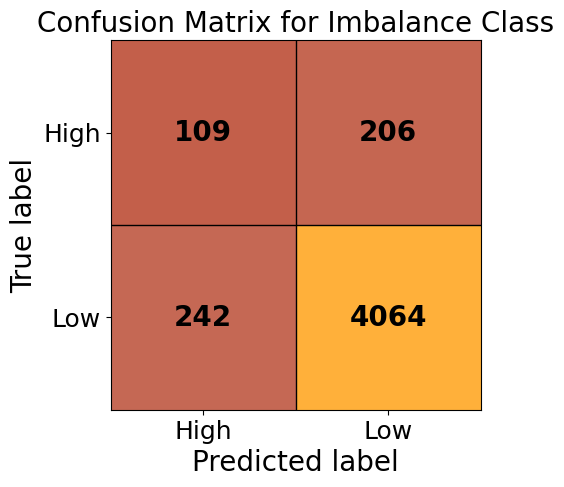

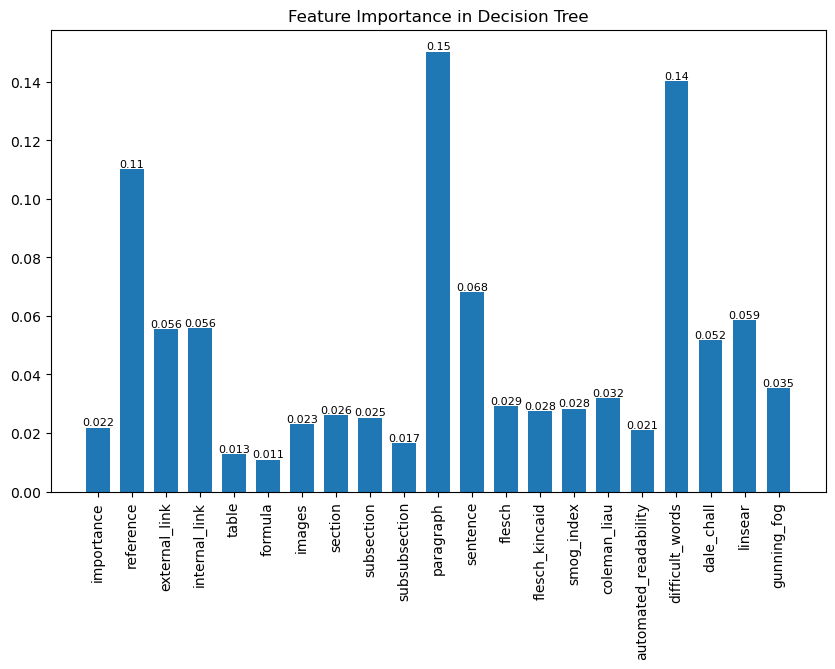

In [18]:
imb_dt_y_proba = prediction_analysis(imb_df, imb_X_train, imb_X_test, 
                                     imb_y_train, imb_y_test, "Decision Tree")

## Decision Tree -  Balance Data

Classifier accuracy: 0.91
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__max_features': None, 'model__min_samples_split': 2, 'model__splitter': 'best'}


,Metric,Value
0,Accuracy,0.91
1,Precision,0.90
2,Recall,0.91
3,AUC,0.95
4,F1 Score,0.91


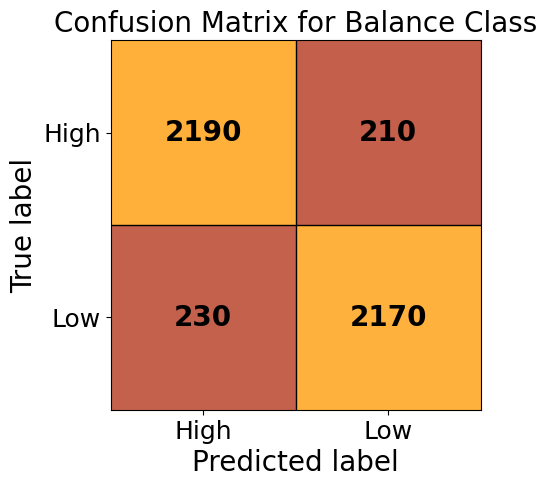

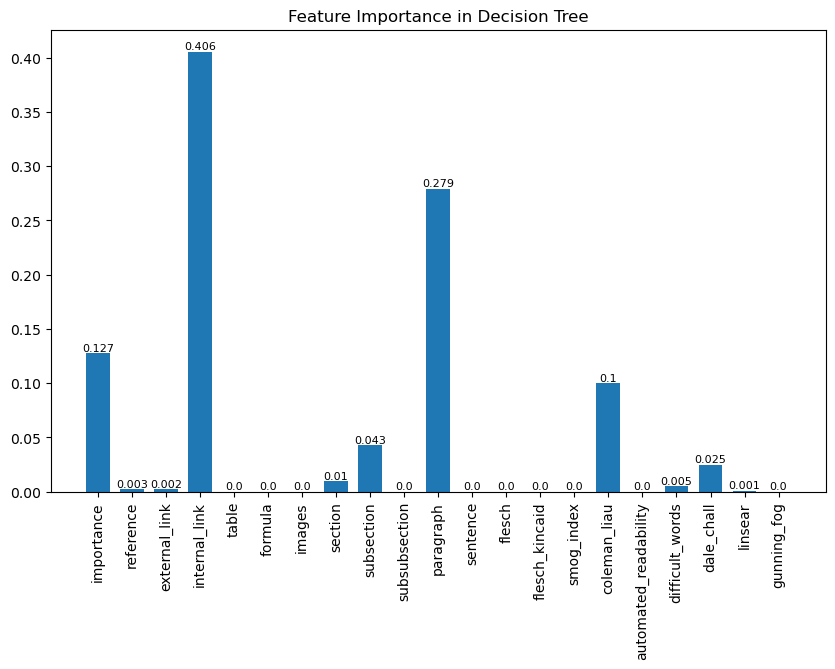

In [19]:
# param_grid = {'model__criterion': ['gini', 'entropy'], 
#               'model__splitter': ['random', 'best'],
#               'model__max_depth': [i for i in range(10, 30, 2)] + [None], 
#               'model__min_samples_split': [i for i in range(2, 50, 5)],
#               'model__max_features': [20, 10, 'sqrt', 'log2', None],
#              }

param_grid = {'model__criterion': ['entropy'], 
              'model__splitter': ['best'],
              'model__max_depth': [5],
              'model__min_samples_split': [2],
              'model__max_features': [None],
             }

b_dt_y_proba = prediction_analysis(b_df, b_X_train, b_X_test,
                                   b_y_train, b_y_test, "Decision Tree",
                                   param_grid, balance = True, cv = True)

## Decision Tree ROC Curve

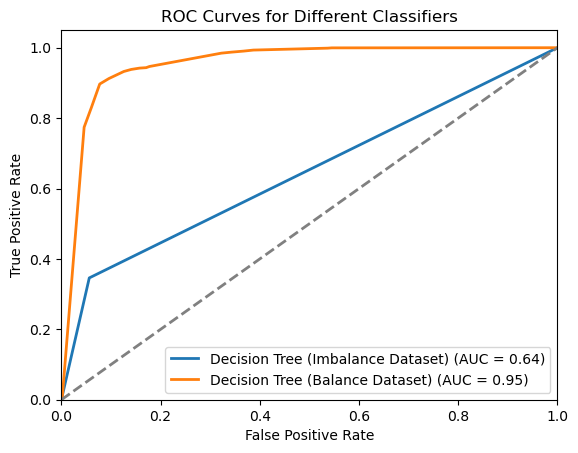

In [20]:
result_proba = {"Decision Tree (Imbalance Dataset)": [imb_y_test, imb_dt_y_proba],
                "Decision Tree (Balance Dataset)": [b_y_test, b_dt_y_proba]}

visualise_roc_curve(result_proba)

## Random Forest - Imbalance Data

Average Cross-Validation Accuracy: 0.94
Best Cross-Validation Accuracy: 0.94
Test Set Accuracy: 0.93


,Metric,Value
0,Accuracy,0.93
1,Precision,0.63
2,Recall,0.10
3,AUC,0.89
4,F1 Score,0.17


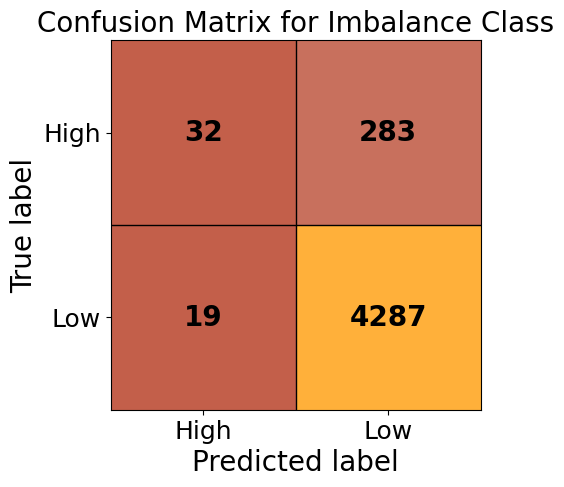

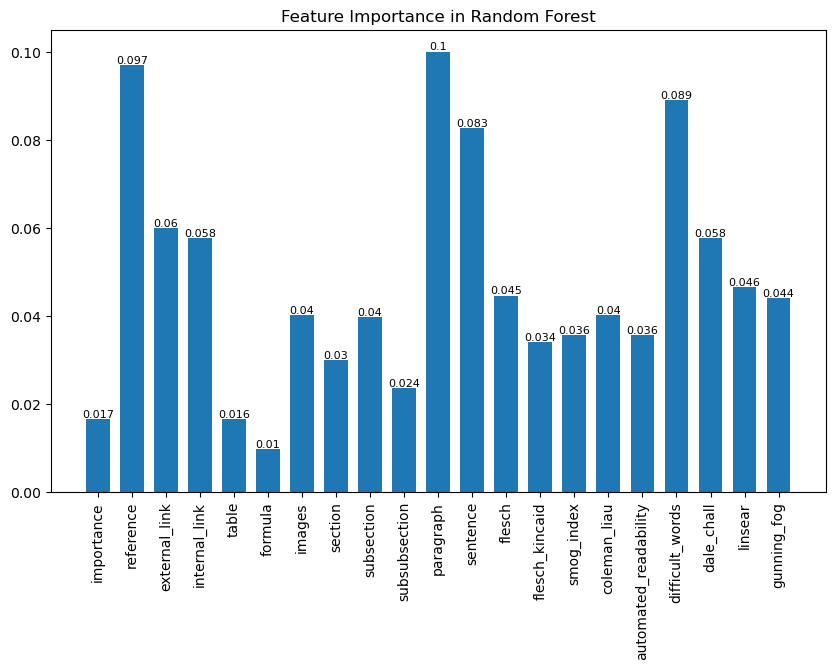

In [21]:
imb_rf_y_proba = prediction_analysis(imb_df, imb_X_train, imb_X_test,
                                     imb_y_train, imb_y_test, "Random Forest")

## Random Forest - Balance Data

Classifier accuracy: 0.97
Best parameters: {'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 150}


,Metric,Value
0,Accuracy,0.97
1,Precision,0.98
2,Recall,0.96
3,AUC,0.99
4,F1 Score,0.97


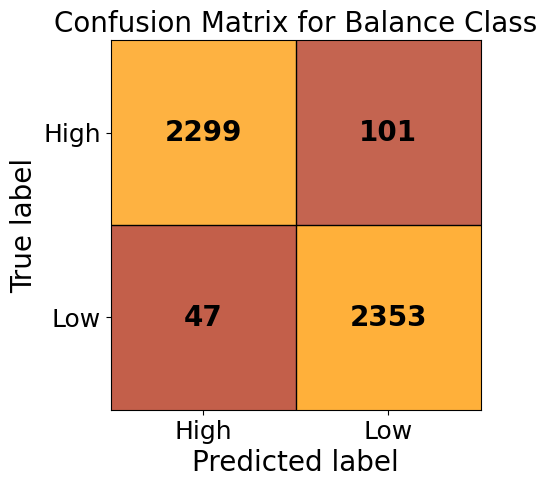

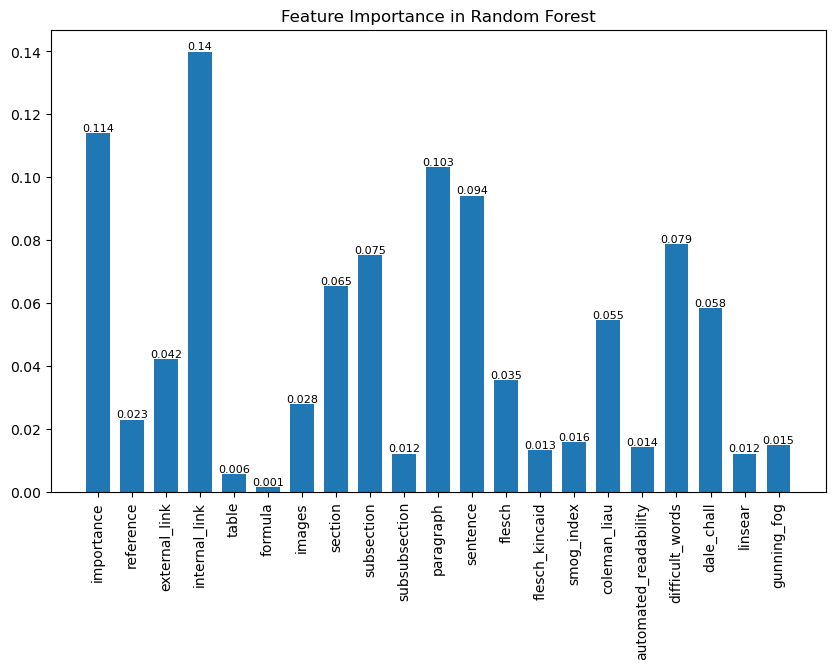

In [22]:
# param_grid = {'model__n_estimators': [i for i in range(100, 200, 50)],
#               'model__criterion': ['gini', 'entropy'],
#               'model__max_depth': [i for i in range(10, 20, 2)] + [None], 
#               'model__min_samples_split': [i for i in range(2, 20, 5)],
#               'model__max_features': [20, 10, 0.3, 'sqrt', 'log2', None],
#              }

param_grid = {'model__n_estimators': [150],
              'model__criterion': ['gini'],
              'model__max_depth': [None], 
              'model__min_samples_split': [2],
              'model__max_features': ['sqrt'],
             }

b_rf_y_proba = prediction_analysis(b_df, b_X_train, b_X_test, 
                                   b_y_train, b_y_test, "Random Forest",
                                   param_grid, balance = True, cv = True)

## Random Forest ROC Curve

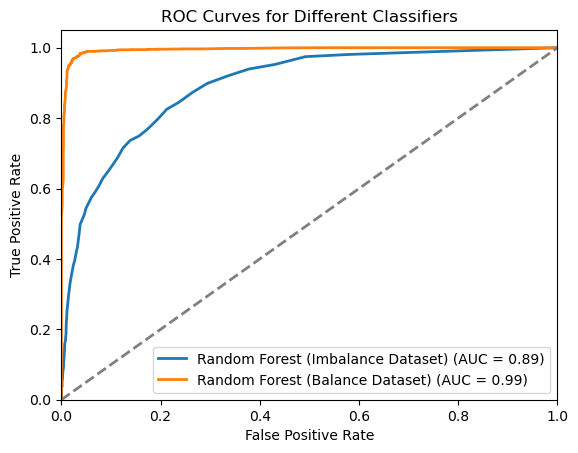

In [23]:
result_proba = {"Random Forest (Imbalance Dataset)": [imb_y_test,imb_rf_y_proba],
                "Random Forest (Balance Dataset)": [b_y_test,b_rf_y_proba]}

visualise_roc_curve(result_proba)